In [1]:
import matplotlib.pyplot as plt
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from models.binary import get_orbit_jax
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np

from jax import config
config.update("jax_enable_x64", True)

m1 = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))
m2 = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))

In [7]:
# def get_orbit_jax(time, m1, m2, P, ecc, T, i, omega, Omega):

orbit = get_orbit_jax(jnp.linspace(0, 100, 100), m1.mass, m2.mass, 10, .5, 0., 0., 0., 0.)

In [8]:
orbit.shape

(6, 3, 100)

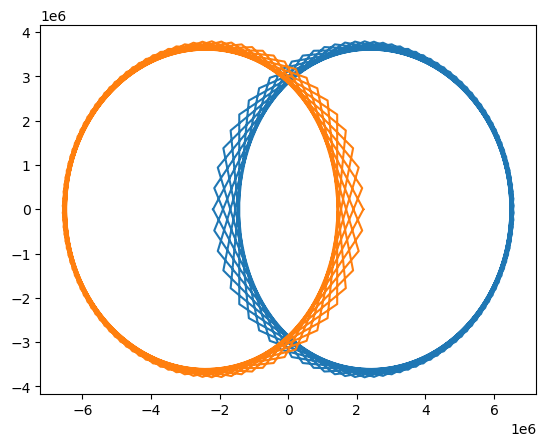

In [13]:
# vec_x_obs, vec_v_obs, vec_x1_obs, vec_v1_obs, vec_x2_obs, vec_v2_obs
#plt.plot(orbit[0, 0, :], orbit[0, 1, :])
plt.plot(orbit[2, 0, :], orbit[2, 1, :])
plt.plot(orbit[4, 0, :], orbit[4, 1, :])

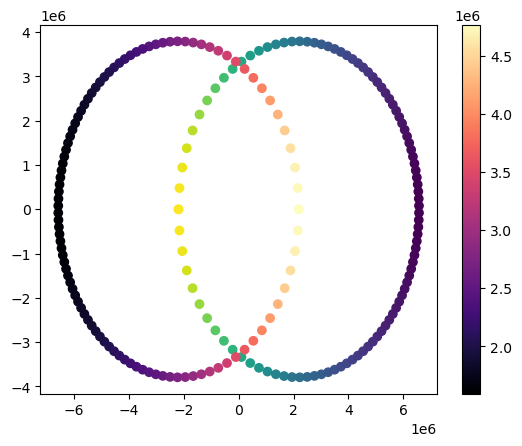

In [22]:
plt.scatter(orbit[2, 0, :], orbit[2, 1, :], c=jnp.linalg.norm(orbit[3], axis=0))
plt.scatter(orbit[4, 0, :], orbit[4, 1, :], c=jnp.linalg.norm(orbit[5], axis=0), cmap='magma')
plt.colorbar()